In [1]:
from __future__ import print_function
from __future__ import absolute_import

from generate_data import generate_nglf_from_matrix, generate_nglf_from_model, \
    generate_general_make_spd, generate_nglf_timeseries
from misc_utils import make_sure_path_exists, make_buckets
from sklearn.model_selection import train_test_split
from theano_time_corex import *

import argparse
import baselines
import json

import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt

# define arguments

In [2]:
class T:
    pass

args = T()

args.nt = 10
args.train_cnt = 16
args.snr = 5.0
args.min_cor = 0.8
args.max_cor = 1.0
args.min_var = 1.0
args.max_var = 1.0

# define the methods

In [4]:
methods = [
    (baselines.TimeVaryingGraphLasso(name='T-GLASSO'), {
        'lamb': 0.3,
        'beta': 0.3,
        'indexOfPenalty': 1,
        'max_iter': 100}),

#     (baselines.TCorex(tcorex=TCorex, name='T-Corex (Sigma)'), {
#         'max_iter': 500,
#         'anneal': True,
#         'l1': 0.1,
#         'reg_type': 'Sigma'
#     }),

#     (baselines.TCorex(tcorex=TCorex, name='T-Corex (W)'), {
#         'max_iter': 500,
#         'anneal': True,
#         'l1': 0.1,
#         'reg_type': 'W'
#     }),

#     (baselines.TCorex(tcorex=TCorexPrior1, name='T-Corex + priors (W, method 1)'), {
#         'max_iter': 500,
#         'anneal': True,
#         'l1': 0.1,
#         'lamb': 0.9,
#         'reg_type': 'W',
#         'init': True
#     }),

    (baselines.TCorex(tcorex=TCorexPrior2, name='T-Corex + priors (W, method 2)'), {
        'max_iter': 500,
        'anneal': True,
        'l1': 0.1,
        'lamb': 0.9,
        'reg_type': 'W',
        'init': True
    }),

    (baselines.TCorex(tcorex=TCorexWeights, name='T-Corex (W, weighted samples)'), {
        'max_iter': 500,
        'anneal': True,
        'l1': 0.1,
        'gamma':2.0,
        'reg_type': 'W',
        'init': True
    }),
]

# start running

In [5]:
nvs = [2**i for i in range(3, 11)]
bss = [nv // 8 for nv in nvs]
ms = [8 for nv in nvs]

times = np.zeros((len(nvs), len(methods)), dtype=np.float64)

In [ ]:
for tid, (m, bs, nv) in enumerate(zip(ms, bss, nvs)):

    (data1, _) = generate_nglf_from_model(nv, m, args.nt // 2, ns=args.train_cnt, snr=args.snr,
                                          min_var=args.min_var, max_var=args.max_var,
                                          min_cor=args.min_cor, max_cor=args.max_cor)
    (data2, _) = generate_nglf_from_model(nv, m, args.nt // 2, ns=args.train_cnt, snr=args.snr,
                                          min_var=args.min_var, max_var=args.max_var,
                                          min_cor=args.min_cor, max_cor=args.max_cor)
    train_data = data1 + data2

    for mid, (method, params) in enumerate(methods):
        name = method.name
        if 'Corex' in name:
            params['nt'] = len(train_data)
            params['nv'] = nv
            params['n_hidden'] = m
        print("Timing {} (nv = {}) .. ".format(name, nv))
        cur_time = method.timeit(train_data, params)
        times[tid, mid] = cur_time
        print("\ttook {:.2f} seconds".format(cur_time))

Fixed SNR: 5.0
Fixed SNR: 5.0
Timing T-GLASSO (nv = 8) .. 
Use l-1 penalty function
10
lambda = 0.3, beta = 0.3
	took 0.46 seconds
Timing T-Corex + priors (W, method 2) (nv = 8) .. 
Annealing iteration finished, time = 1.35418701172
Annealing iteration finished, time = 1.36196804047
Annealing iteration finished, time = 1.36006188393
Annealing iteration finished, time = 1.35849690437
Annealing iteration finished, time = 1.35912489891
Annealing iteration finished, time = 1.36250495911
Annealing iteration finished, time = 1.35657691956
	took 15.69 seconds
Timing T-Corex (W, weighted samples) (nv = 8) .. 
Annealing iteration finished, time = 1.27361702919
Annealing iteration finished, time = 1.27823400497
Annealing iteration finished, time = 1.27719902992
Annealing iteration finished, time = 1.27160692215
Annealing iteration finished, time = 1.29146003723
Annealing iteration finished, time = 1.28294610977
Annealing iteration finished, time = 1.27820611
	took 14.71 seconds
Fixed SNR: 5.0
Fi

In [ ]:
np.savetxt('times.npy', times)

<IPython.core.display.Javascript object>


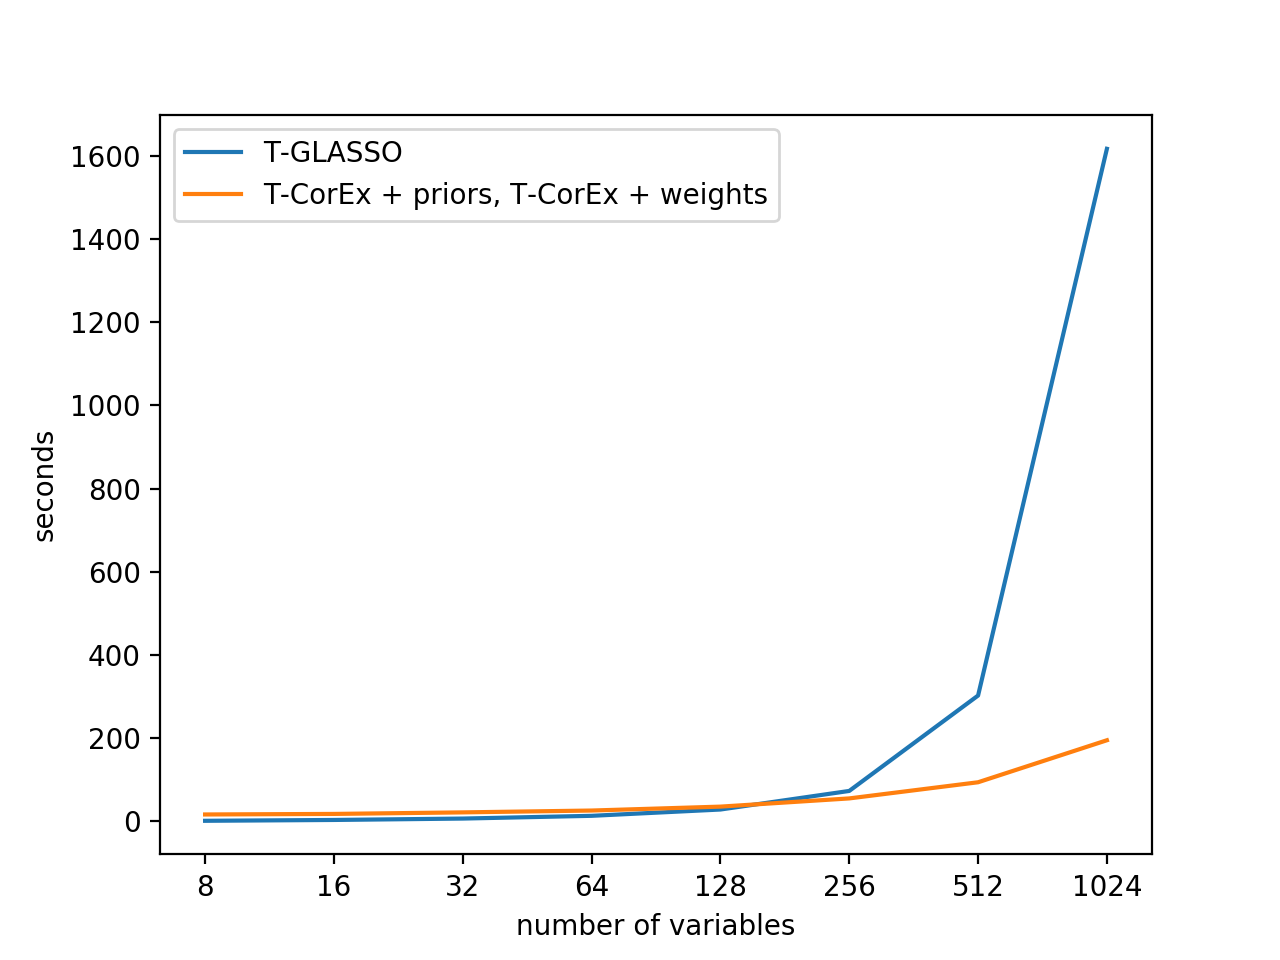

In [24]:
plt.figure()
plt.plot(times[:, 0])
plt.plot(times[:, 1])
# plt.plot(times[:, 2])
plt.xticks(range(len(times)), nvs)
plt.legend(['T-GLASSO', 'T-CorEx + priors, T-CorEx + weights'])
#plt.legend([method.name for method, params in methods])
plt.ylabel('seconds')
plt.xlabel('number of variables')

<IPython.core.display.Javascript object>


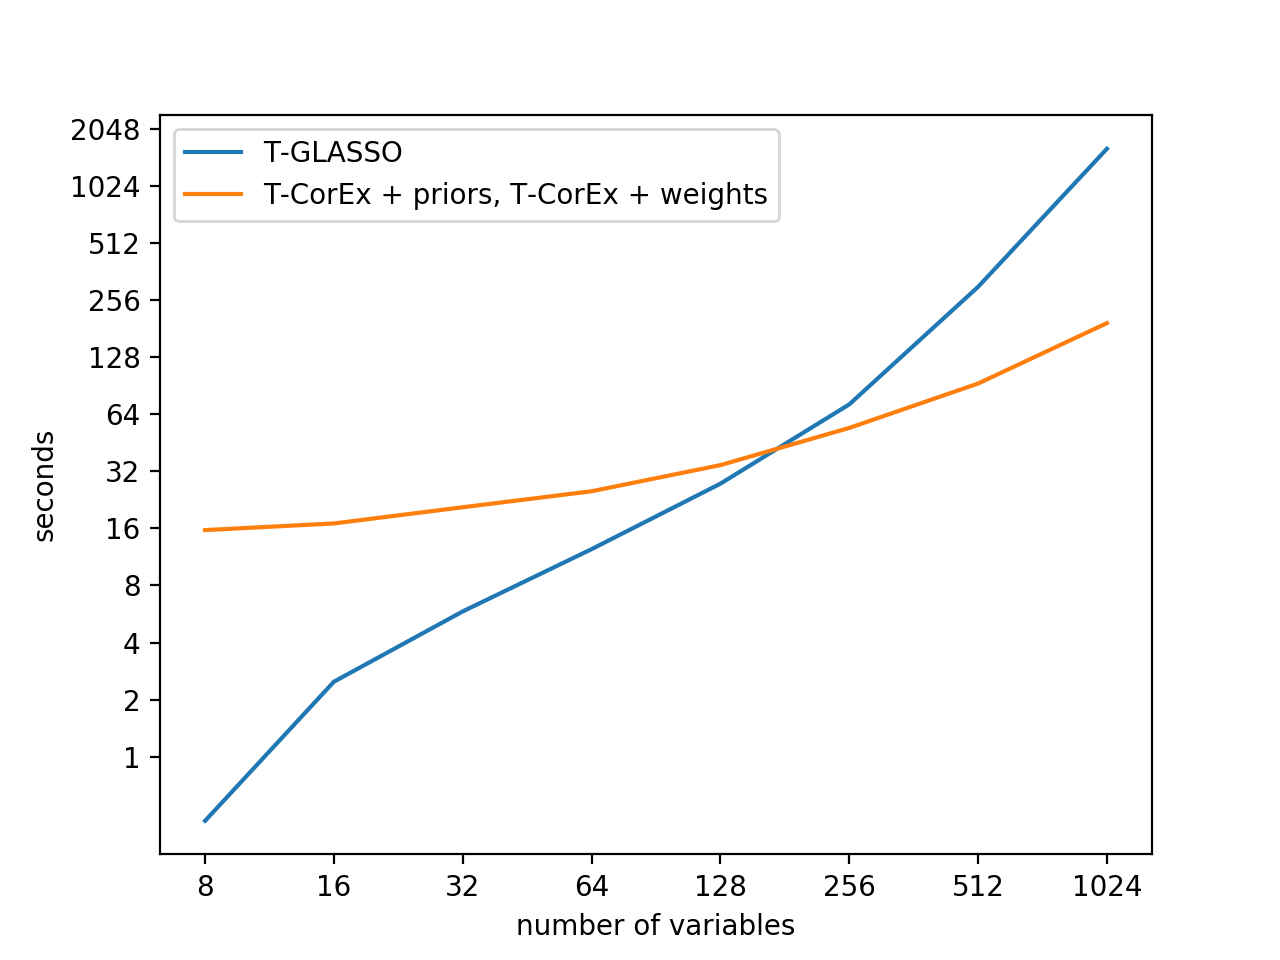

In [28]:
plt.figure()
plt.plot(np.log2(times[:, 0]))
plt.plot(np.log2(times[:, 1]))
# plt.plot(np.log2(times[:, 2]))
plt.xticks(range(len(times)), nvs)
plt.legend(['T-GLASSO', 'T-CorEx + priors, T-CorEx + weights'])
#plt.legend([method.name for method, params in methods])
plt.ylabel('seconds')
plt.yticks(range(12), [2**i for i in range(12)])
plt.xlabel('number of variables')

<IPython.core.display.Javascript object>


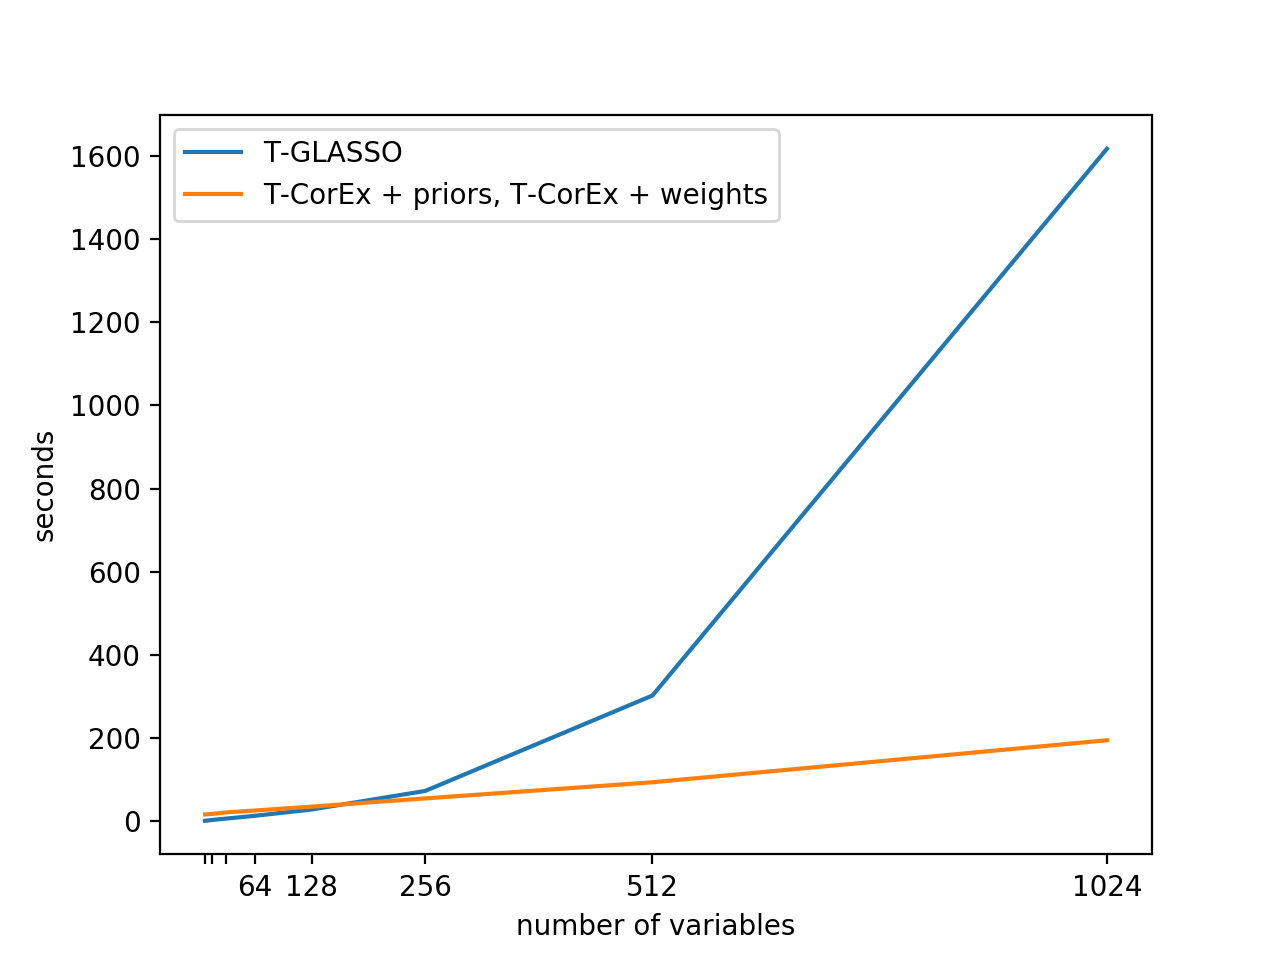

In [31]:
plt.figure()
plt.plot(nvs, times[:, 0])
plt.plot(nvs, times[:, 1])
# plt.plot(nvs, times[:, 2])
plt.xticks(nvs, ['' if x < 64 else x for x in nvs])
plt.legend(['T-GLASSO', 'T-CorEx + priors, T-CorEx + weights'])
#plt.legend([method.name for method, params in methods])
plt.ylabel('seconds')
plt.xlabel('number of variables')

## $2^{11}$, $2^{12}$

In [32]:
ext_nvs = [2**i for i in range(11, 15)]
ext_bss = [nv // 8 for nv in ext_nvs]
ext_ms = [8 for nv in ext_nvs]

times_ext = np.zeros((len(ext_nvs), len(methods)), dtype=np.float64)

In [ ]:
for tid, (m, bs, nv) in enumerate(zip(ext_ms, ext_bss, ext_nvs)):

    (data1, _) = generate_nglf_from_model(nv, m, args.nt // 2, ns=args.train_cnt, snr=args.snr,
                                          min_var=args.min_var, max_var=args.max_var,
                                          min_cor=args.min_cor, max_cor=args.max_cor)
    (data2, _) = generate_nglf_from_model(nv, m, args.nt // 2, ns=args.train_cnt, snr=args.snr,
                                          min_var=args.min_var, max_var=args.max_var,
                                          min_cor=args.min_cor, max_cor=args.max_cor)
    train_data = data1 + data2

    for mid, (method, params) in enumerate(methods):
        if mid != 1:
            print("Skipping {} ...".format(method.name))
            continue
        name = method.name
        if 'Corex' in name:
            params['nt'] = len(train_data)
            params['nv'] = nv
            params['n_hidden'] = m
        print("Timing {} (nv = {}) .. ".format(name, nv))
        cur_time = method.timeit(train_data, params)
        times_ext[tid, mid] = cur_time
        print("\ttook {:.2f} seconds".format(cur_time))

Fixed SNR: 5.0
Fixed SNR: 5.0
Skipping T-GLASSO ...
Timing T-Corex + priors (W, method 2) (nv = 2048) .. 


In [37]:
times_ext

array([[    0.        ,   397.28011608,     0.        ],
       [    0.        ,   842.91522288,     0.        ],
       [    0.        ,  2927.151788  ,     0.        ],
       [    0.        ,     0.        ,     0.        ]])

# Plot extended plots

<IPython.core.display.Javascript object>


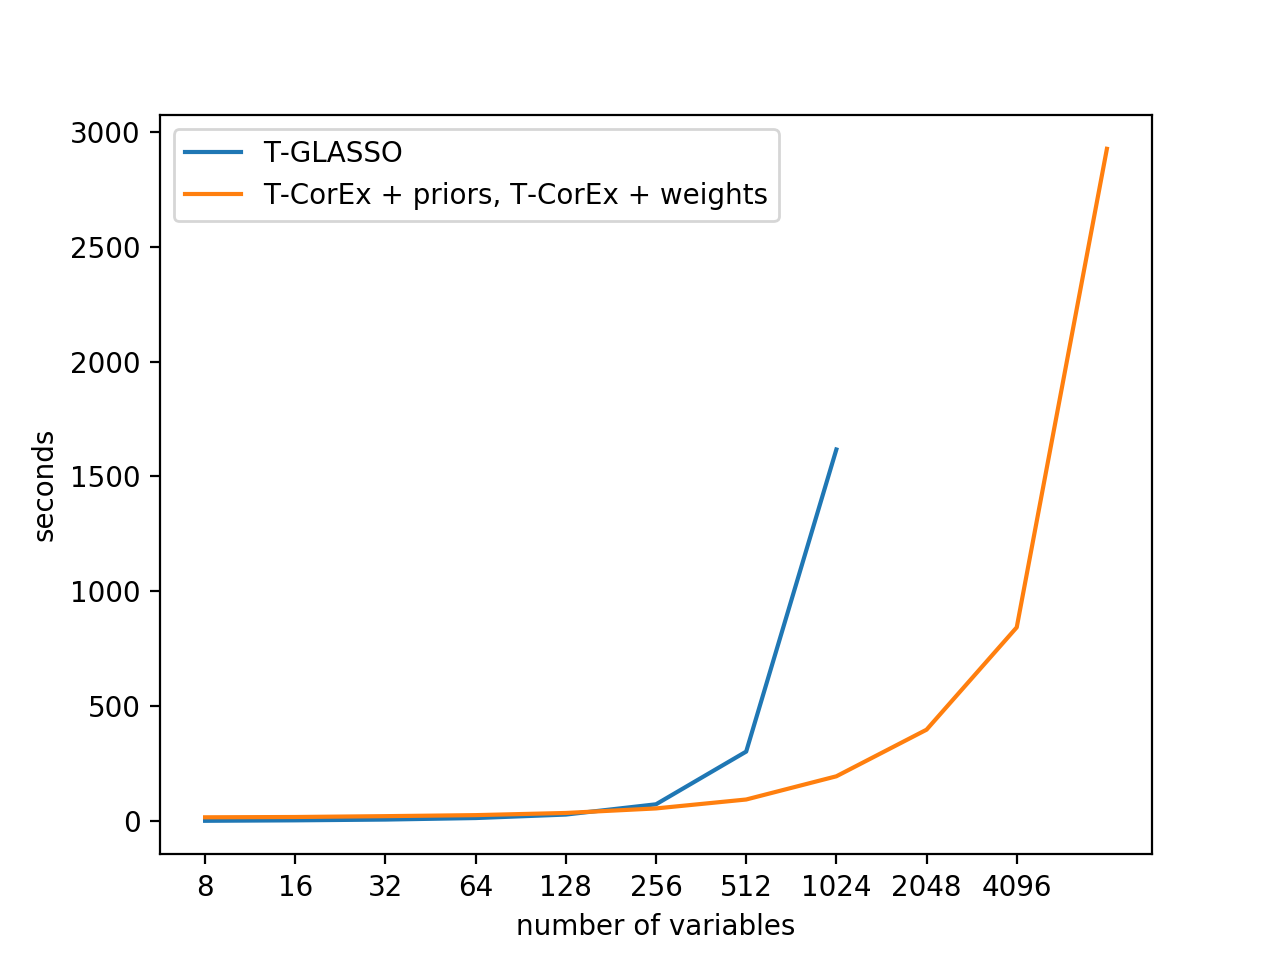

In [43]:
plt.figure()
plt.plot(times[:, 0])
plt.plot(np.concatenate([times[:, 1], times_ext[:-1, 1]], axis=0))
plt.xticks(range(len(times)+2), nvs+[2048, 4096, 8192])
plt.legend(['T-GLASSO', 'T-CorEx + priors, T-CorEx + weights'])
plt.ylabel('seconds')
plt.xlabel('number of variables')

<IPython.core.display.Javascript object>


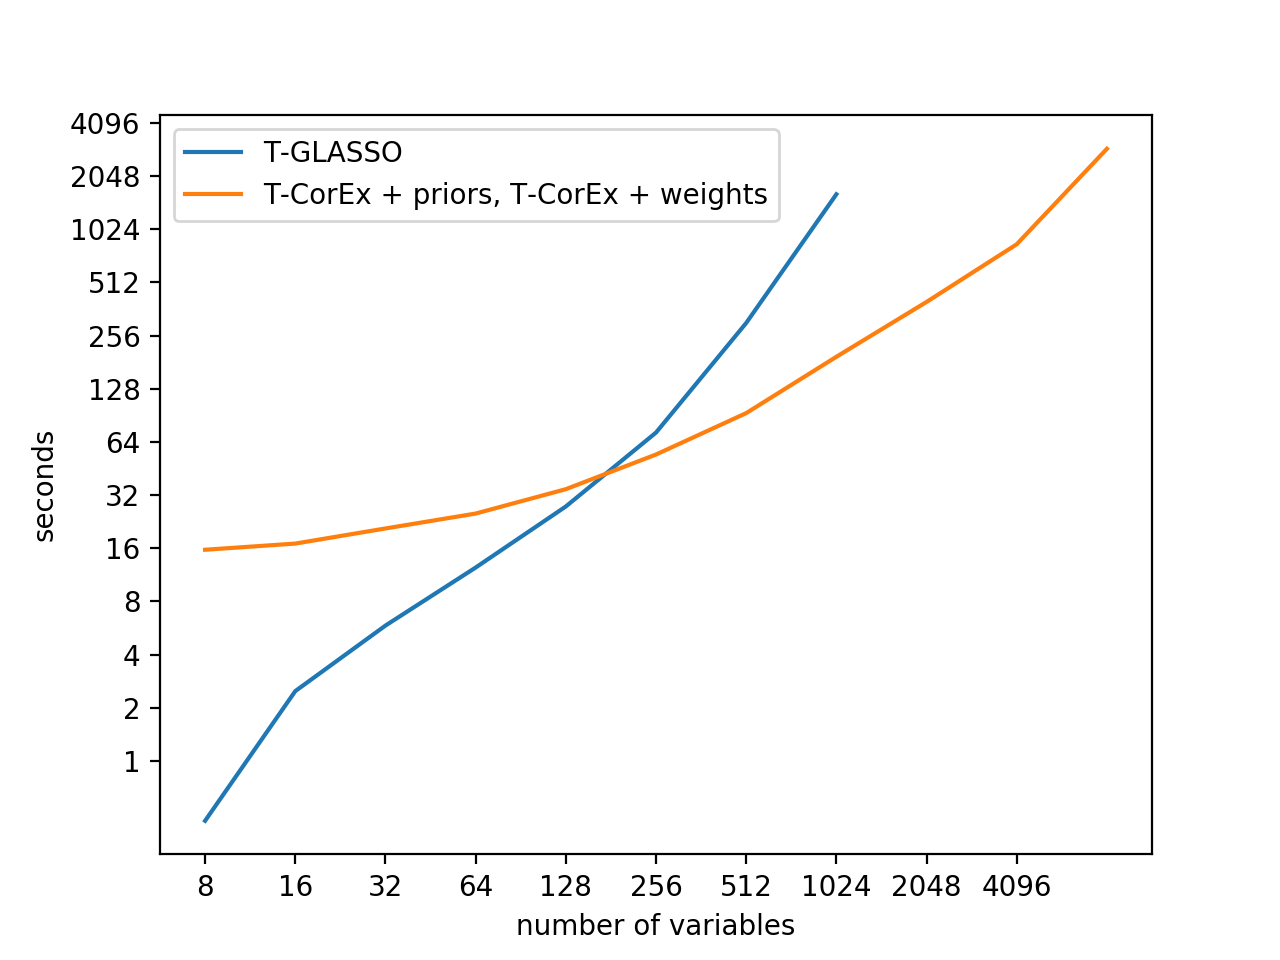

In [44]:
plt.figure()
plt.plot(np.log2(times[:, 0]))
plt.plot(np.log2(np.concatenate([times[:, 1], times_ext[:-1, 1]], axis=0)))
plt.xticks(range(len(times)+2), nvs+[2048, 4096, 8192])
plt.legend(['T-GLASSO', 'T-CorEx + priors, T-CorEx + weights'])
plt.ylabel('seconds')
plt.yticks(range(13), [2**i for i in range(13)])
plt.xlabel('number of variables')

<IPython.core.display.Javascript object>


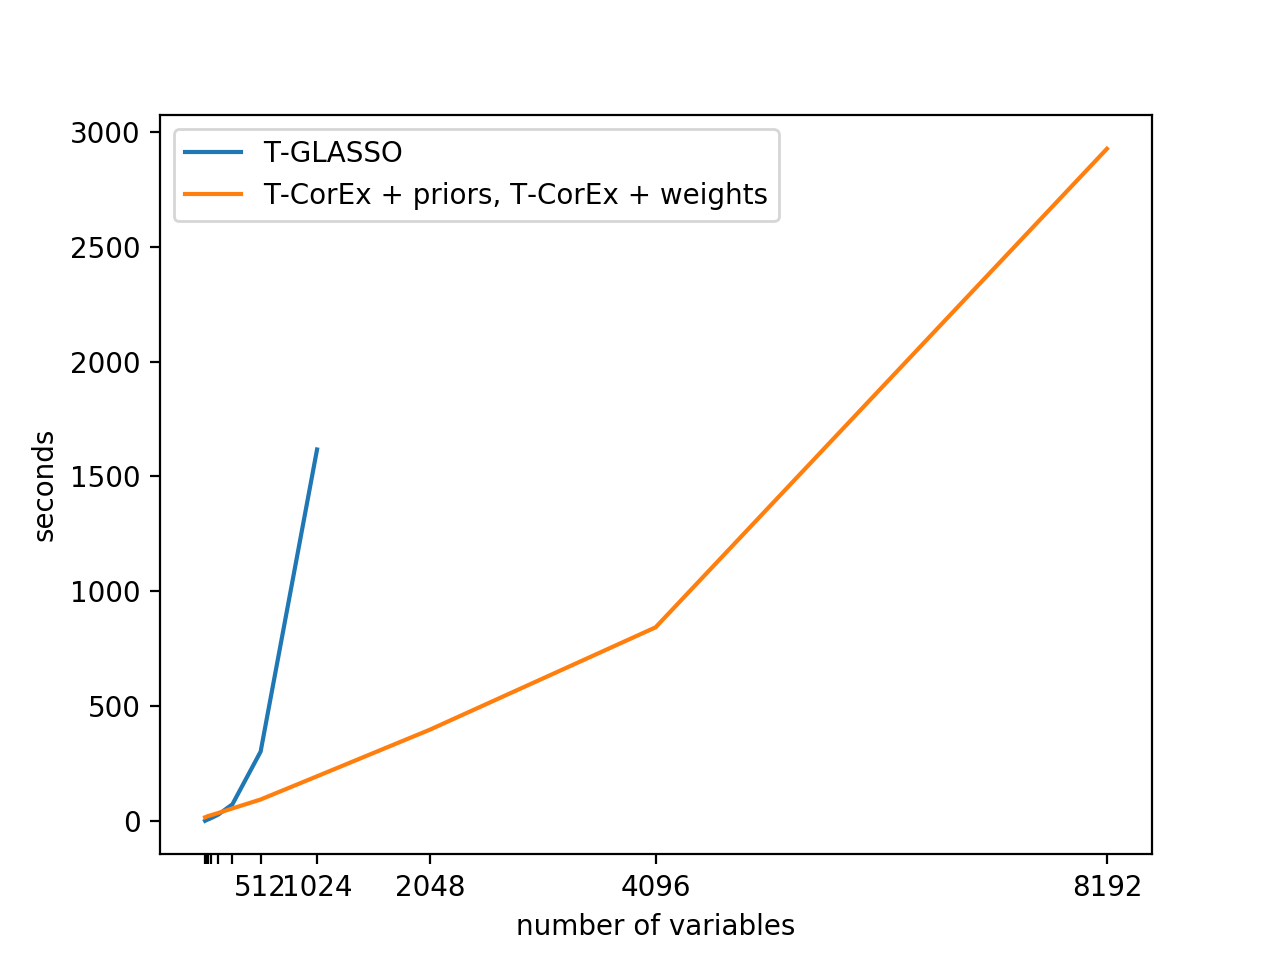

In [48]:
plt.figure()
plt.plot(nvs, times[:, 0])
plt.plot(nvs+[2048, 4096, 8192], np.concatenate([times[:, 1], times_ext[:-1, 1]], axis=0))
plt.xticks(nvs+[2048, 4096, 8192], ['' if x < 512 else x for x in nvs+[2048, 4096, 8192]])
plt.legend(['T-GLASSO', 'T-CorEx + priors, T-CorEx + weights'])
plt.ylabel('seconds')
plt.xlabel('number of variables')